In [67]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
parent_path = Path().resolve().parent.parent
sys.path.append(str(parent_path))
# from data_tools import data_utils

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = project_dir = Path.cwd().parent
trunc_D = 10
print(project_dir)
data_utils.create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)


train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 0
M = 10
D = 10



/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [68]:
train_df

,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9
Date_Symptoms,,,,,,,,,,
2013-01-11,53,55,35,116,64,54,65,39,1,1
2013-01-12,30,56,110,91,63,61,62,7,4,37
2013-01-13,21,113,100,70,69,55,8,8,71,25
2013-01-14,47,105,99,105,80,25,14,131,47,21
2013-01-15,51,119,87,70,28,23,115,66,29,19
...,...,...,...,...,...,...,...,...,...,...
2018-07-30,14,20,17,13,11,2,2,12,5,3
2018-07-31,7,20,13,12,4,3,2,2,2,0
2018-08-01,5,18,11,8,3,16,6,3,3,3


In [63]:
Z_data = train_df.copy().values[start_index: start_index + M + D]
y_data = train_df.copy()[start_index: start_index + M + D].sum(axis=1)
y_data.index = pd.to_datetime(y_data.index)
mask = np.ones_like(Z_data, dtype=bool)

def mask_matrix(matrix):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

mask[-D:] = mask_matrix(np.array(mask[-D:]))


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

t = np.arange(0, len(Z_data))
# Ensures not forward looking
Z_data[~mask] = 0

Z_data

array([[ 53,  55,  35, 116,  64,  54,  65,  39,   1,   1],
       [ 30,  56, 110,  91,  63,  61,  62,   7,   4,  37],
       [ 21, 113, 100,  70,  69,  55,   8,   8,  71,  25],
       [ 47, 105,  99, 105,  80,  25,  14, 131,  47,  21],
       [ 51, 119,  87,  70,  28,  23, 115,  66,  29,  19],
       [ 46, 111,  96,  36,  25, 123,  69,  52,  38,  27],
       [ 49, 158,  43,  26, 134,  77,  77,  63,  30,   3],
       [ 51,  60,  48, 169,  80,  73,  70,  70,   4,   2],
       [ 42,  81, 165, 115,  80,  91,  66,  10,   0,  27],
       [ 44, 124, 115, 124,  98,  60,  11,  16,  55,  22],
       [138, 184, 137, 129, 106,  14,   7, 107,  42,  30],
       [127, 162, 148,  98,  26,  19,  97,  72,  36,   0],
       [102, 222, 138,  44,  31, 107,  77,  75,   0,   0],
       [181, 188,  65,  43, 149,  93,  95,   0,   0,   0],
       [106,  86,  48, 192, 104, 110,   0,   0,   0,   0],
       [ 83,  80, 186, 128, 106,   0,   0,   0,   0,   0],
       [ 74, 195, 166, 139,   0,   0,   0,   0,   0,   0

Time varying prop vector

In [64]:

def proportion_net(Z_data, n_hidden=10, output_dim=D):
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw

with pm.Model() as NN_time_dep_model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)

    # Linear trend parameters
    b0 = pm.Normal("b0", mu=0, sigma=0.5)   # intercept
    b1 = pm.Normal("b1", mu=0, sigma=0.5)
    mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


    ell = pm.Gamma("ell", alpha=10, beta=1)   # length scale
    eta = pm.HalfNormal("eta", sigma=2)      # amplitude
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    f = gp.prior("f", X=t_shared[:, None])

    fourier_shared = create_fourier_features(t_shared, n=10, p=3.5)
    beta_fourier = pm.Normal("beta_fourier", 0, 0.1, shape=fourier_shared.shape[1])
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(fourier_shared, beta_fourier)
    )
    
    log_lam = f + seasonality
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    
    p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p

    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    approx  = pm.fit(method='advi', n=50000)
    idata = approx.sample(1000)

with NN_time_dep_model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    


Output()

Finished [100%]: Average Loss = 1,054.7
Sampling: [z]


Output()

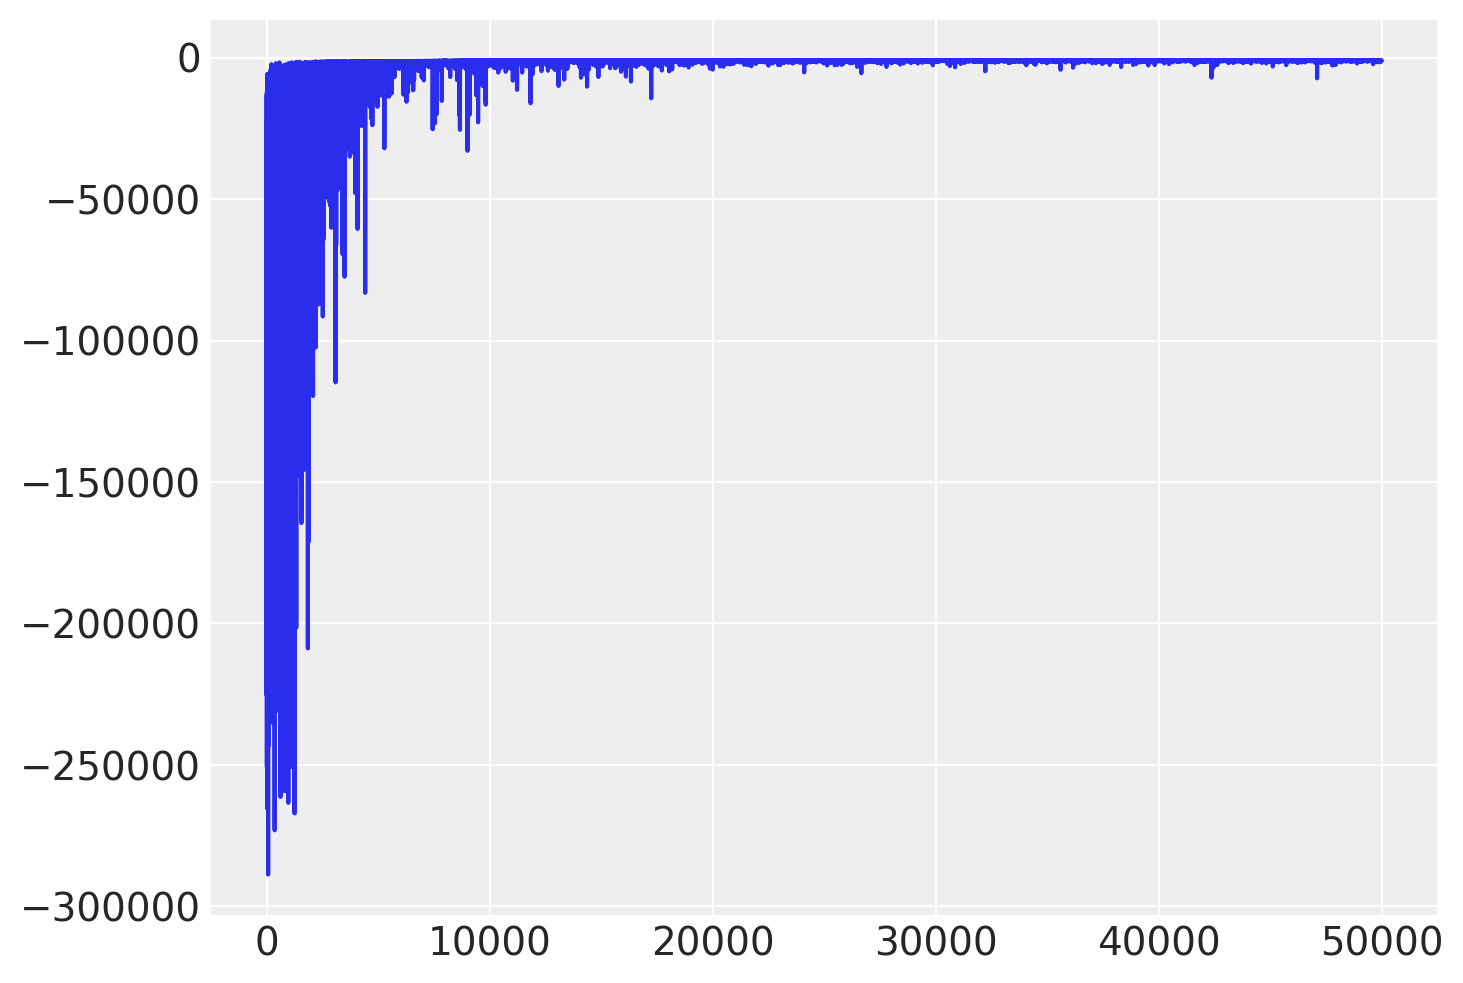

In [66]:
plt.plot(-approx.hist)

In [ ]:
p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
print(p_post_samples[-1, :, 0].values)

[0.19027605 0.19777357 0.14467814 0.06543644 0.05295995 0.13184069
 0.08204991 0.06652971 0.05606874 0.0123868 ]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_60796/2389668266.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/1809363769.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/1809363769.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


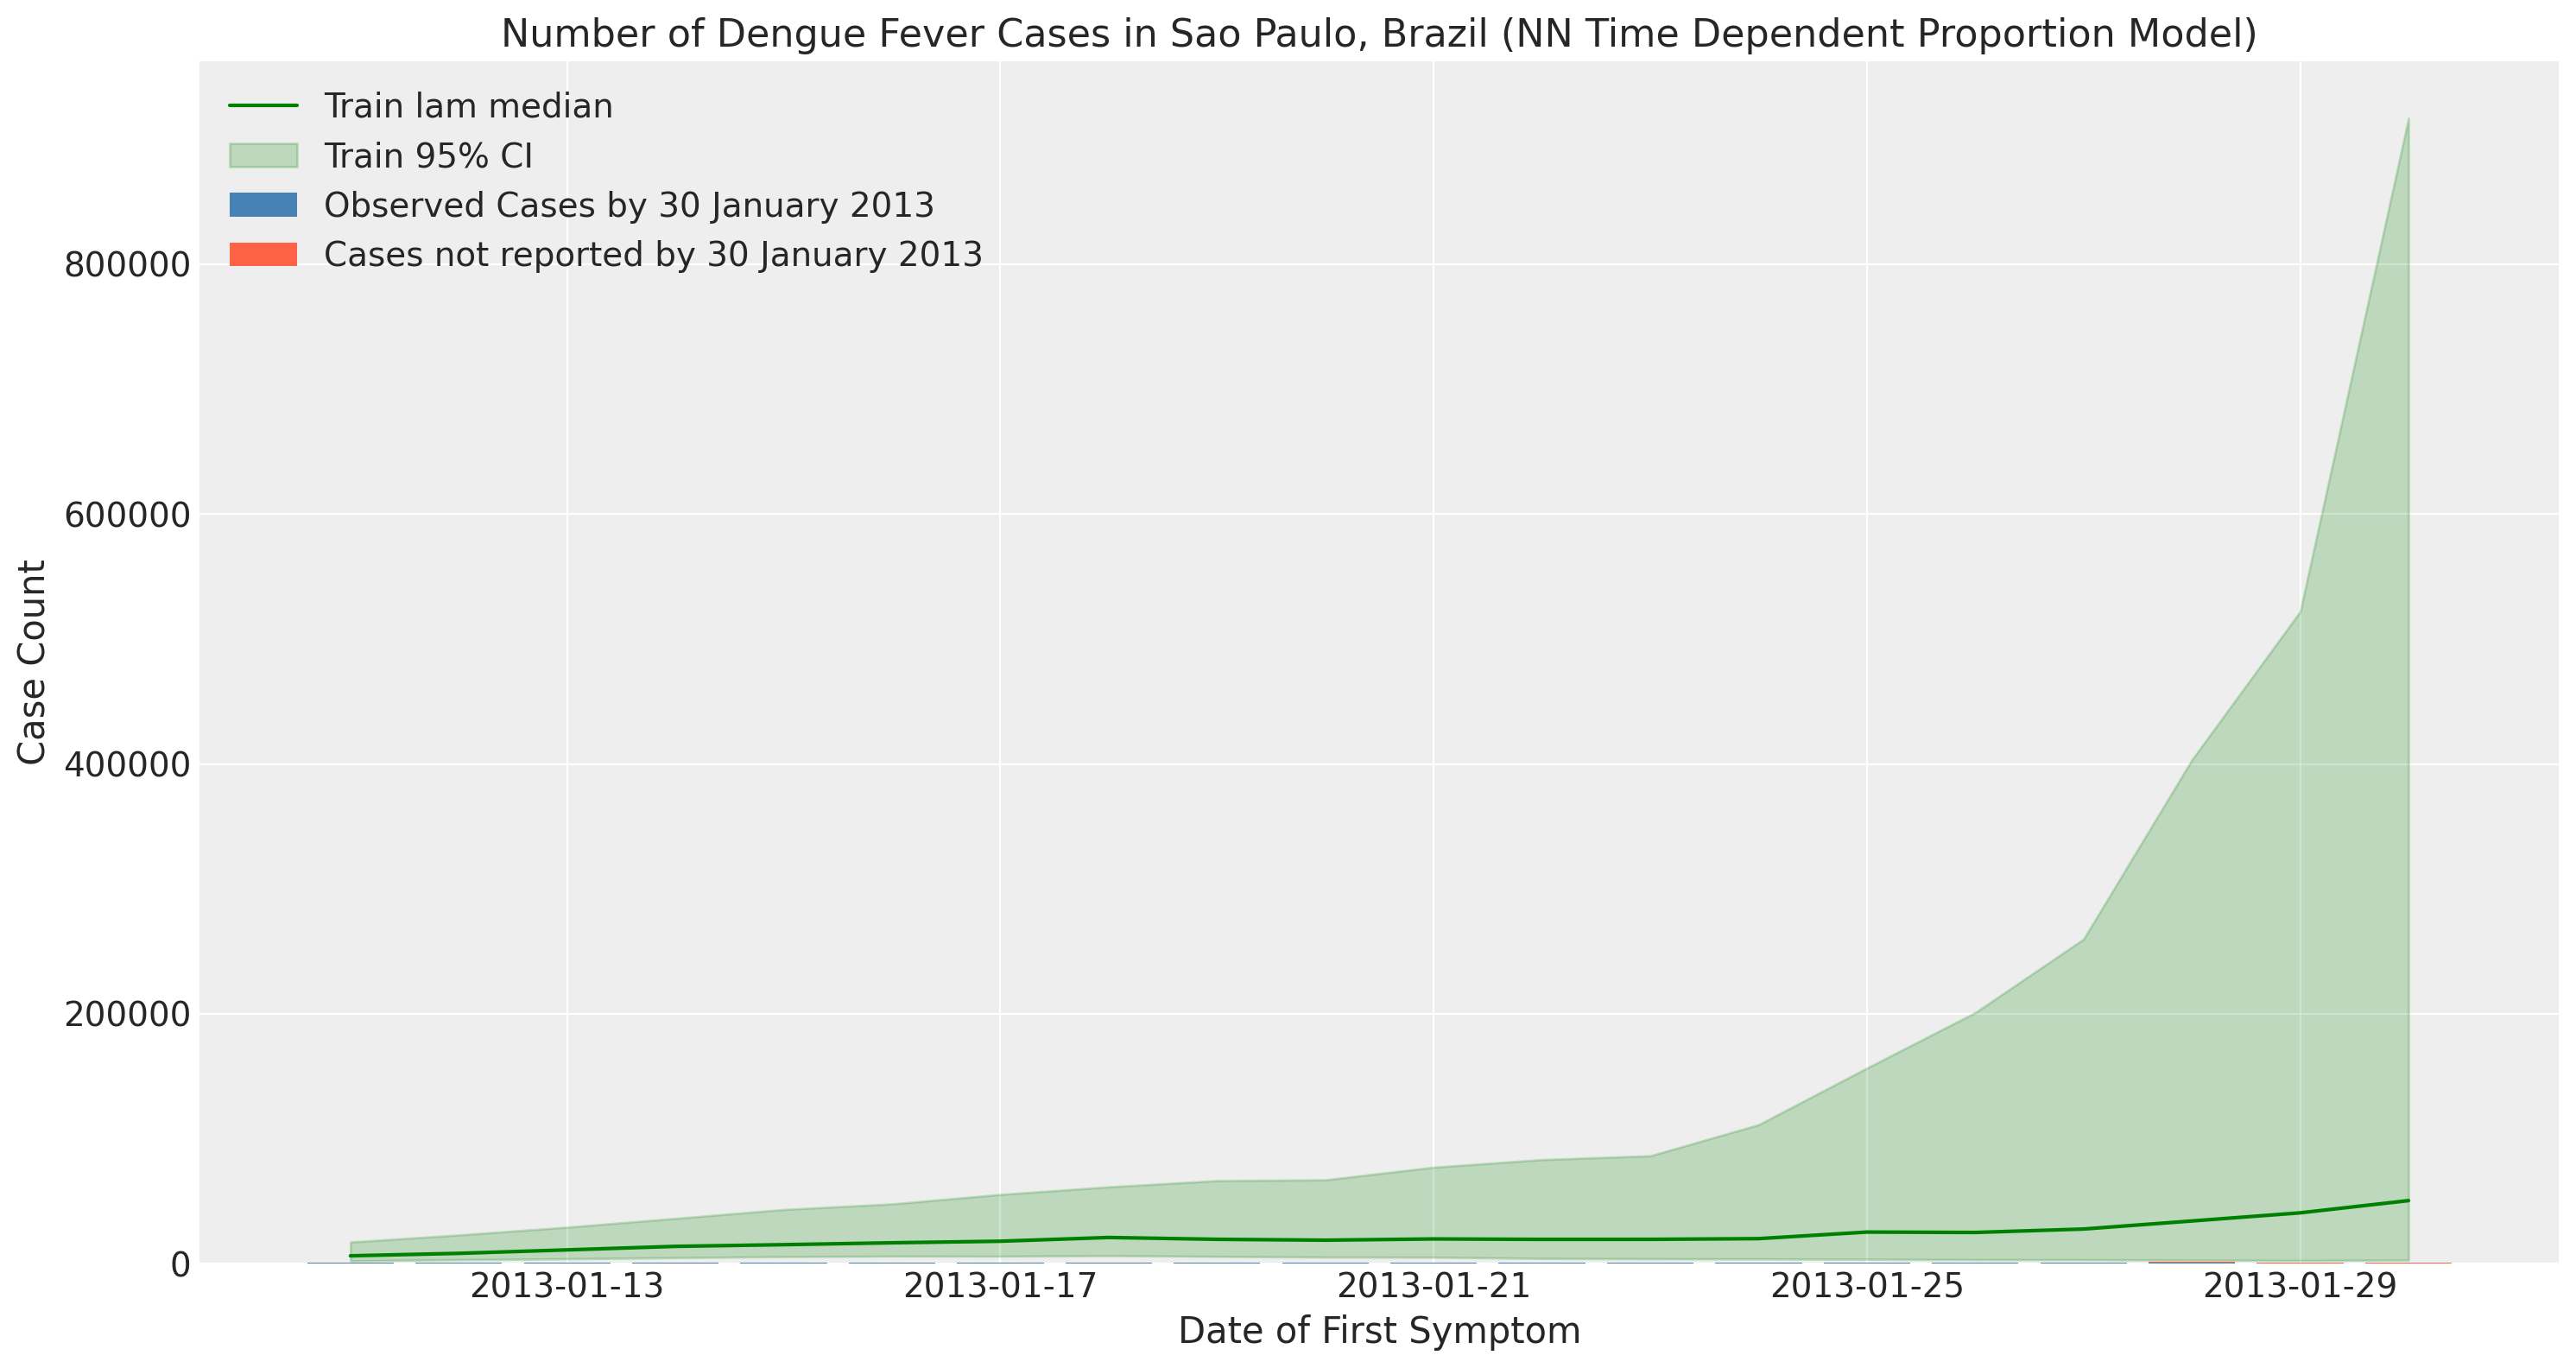

In [65]:
y_obs = Z_data.sum(1)
y_gap = y_data - y_obs

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)




# Plot stacked bars
plt.figure(figsize=(15, 8))

plt.bar(y_data.index, y_obs, color="steelblue", label=f"Observed Cases by {y_data.index[-1].strftime("%d %B %Y")}")
plt.bar(y_data.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y_data.index[-1].strftime("%d %B %Y")}")

# Plot CI for training data
plt.plot(y_data.index,  med_train, color='green', label="Train lam median")
plt.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.2, label='Train 95% CI')


plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (NN Time Dependent Proportion Model)")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()

Constant Prop vector

In [ ]:
def proportion_net(Z_data, n_hidden=10, output_dim=D):
    T,D = Z_data.shape
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(T*D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h0 = pm.math.flatten(Z_data)
    h1 = pm.math.tanh(pm.math.dot(h0, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw

with pm.Model() as NN_time_indep_model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)

    # Linear trend parameters
    b0 = pm.Normal("b0", mu=0, sigma=0.5)   # intercept
    b1 = pm.Normal("b1", mu=0, sigma=0.5)
    mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


    ell = pm.Gamma("ell", alpha=10, beta=1)   # length scale
    eta = pm.HalfNormal("eta", sigma=2)      # amplitude
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    f = gp.prior("f", X=t_shared[:, None])

    fourier_shared = create_fourier_features(t_shared, n=10, p=3.5)
    beta_fourier = pm.Normal("beta_fourier", 0, 0.1, shape=fourier_shared.shape[1])
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(fourier_shared, beta_fourier)
    )
    
    log_lam = f + seasonality
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    
    p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=0))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p[None, :]

    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    idata = pm.sample(**sampler_kwargs())

with NN_time_indep_model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/model/fgraph.py:163: UserWarning: Detected variables likely created by GP objects. Further use of these old GP objects should be avoided as it may reintroduce variables from the old model. See issue: https://github.com/pymc-devs/pymc/issues/6883
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,405,0,0.00,1023
,396,0,0.00,1023


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (2) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


IndexError: list index out of range

In [ ]:
p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
print(p_post_samples.median(axis=1))

<xarray.DataArray 'p' (p_dim_0: 10)> Size: 80B
array([0.09507456, 0.15891093, 0.14370409, 0.13104924, 0.10618616,
       0.09256544, 0.08682106, 0.0711017 , 0.05695644, 0.04228586])
Coordinates:
  * p_dim_0  (p_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_60796/3791433100.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_60796/3885947044.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_60796/3885947044.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


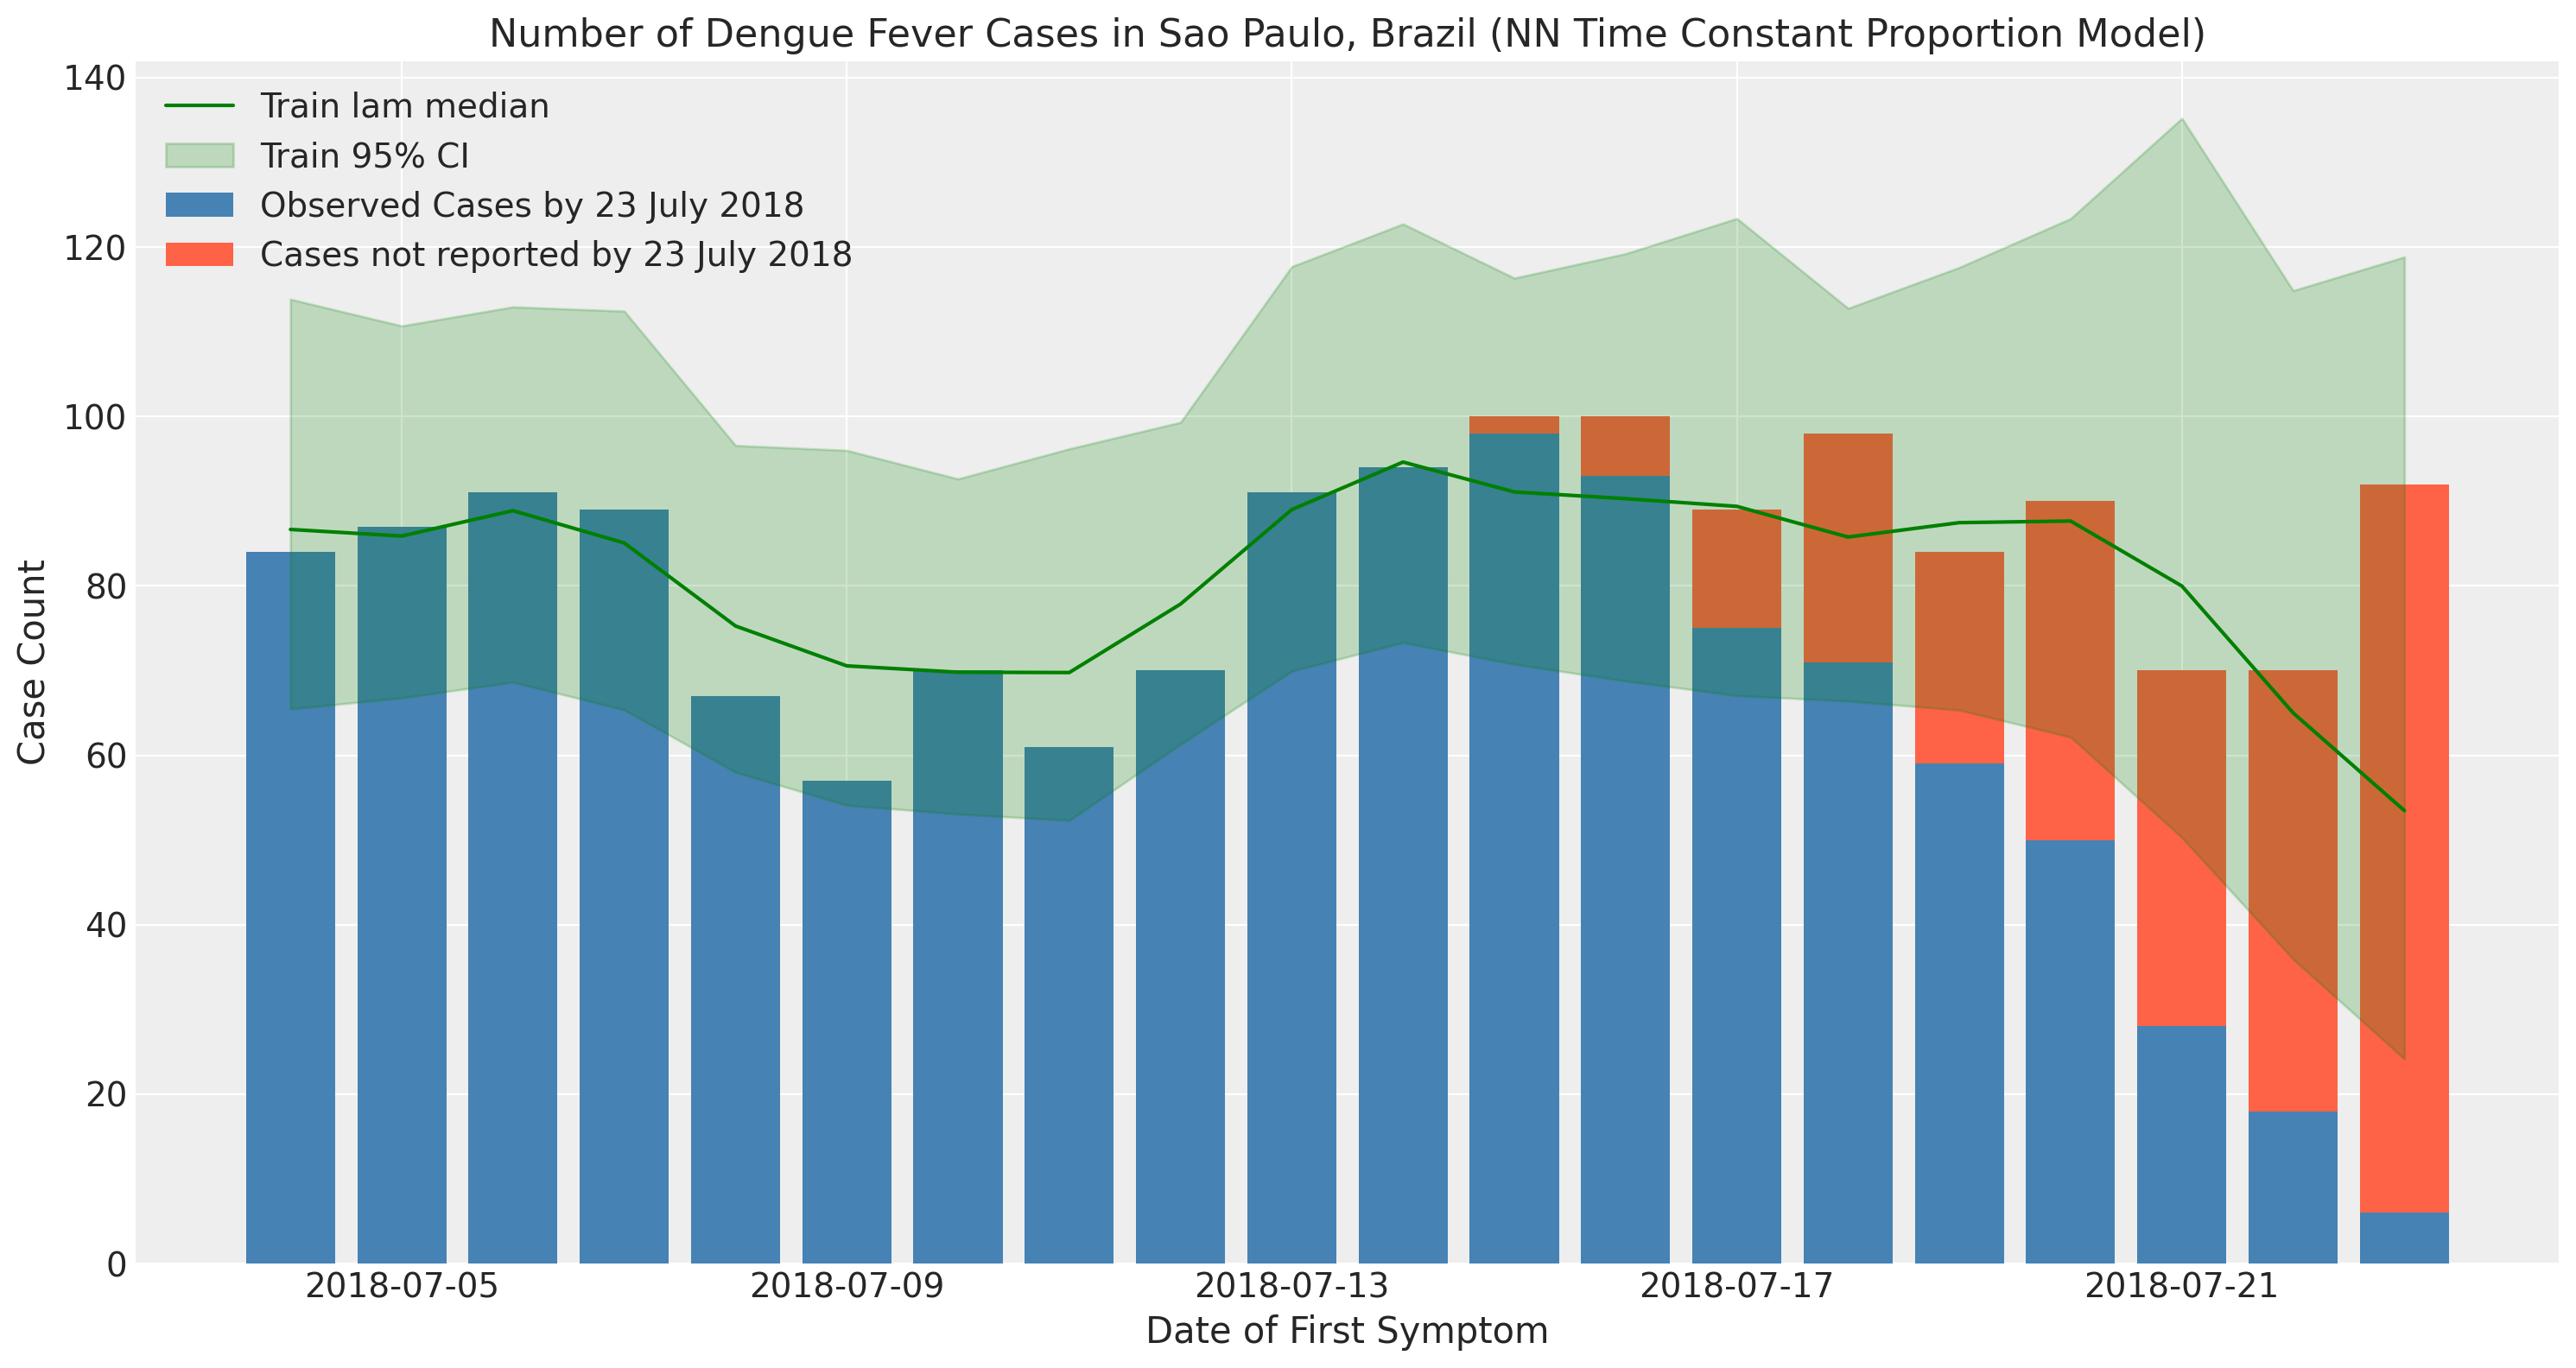

In [ ]:
y_obs = Z_data.sum(1)
y_gap = y_data - y_obs

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)




# Plot stacked bars
plt.figure(figsize=(15, 8))

plt.bar(y_data.index, y_obs, color="steelblue", label=f"Observed Cases by {y_data.index[-1].strftime("%d %B %Y")}")
plt.bar(y_data.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y_data.index[-1].strftime("%d %B %Y")}")

# Plot CI for training data
plt.plot(y_data.index,  med_train, color='green', label="Train lam median")
plt.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.2, label='Train 95% CI')


plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (NN Time Constant Proportion Model)")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()

Prop Prior

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.58,7
,1300,0,0.57,7


Sampling: [p, z]


Output()

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/3192138189.py:68: FutureWarning: extract_dataset has been deprecated, please use extract
  p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/3192138189.py:75: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/3192138189.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<xarray.DataArray 'p' (p_dim_0: 10)> Size: 80B
array([0.10311746, 0.16881266, 0.14423923, 0.13584776, 0.10416472,
       0.09027727, 0.08384583, 0.07943836, 0.04528493, 0.03083932])
Coordinates:
  * p_dim_0  (p_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9


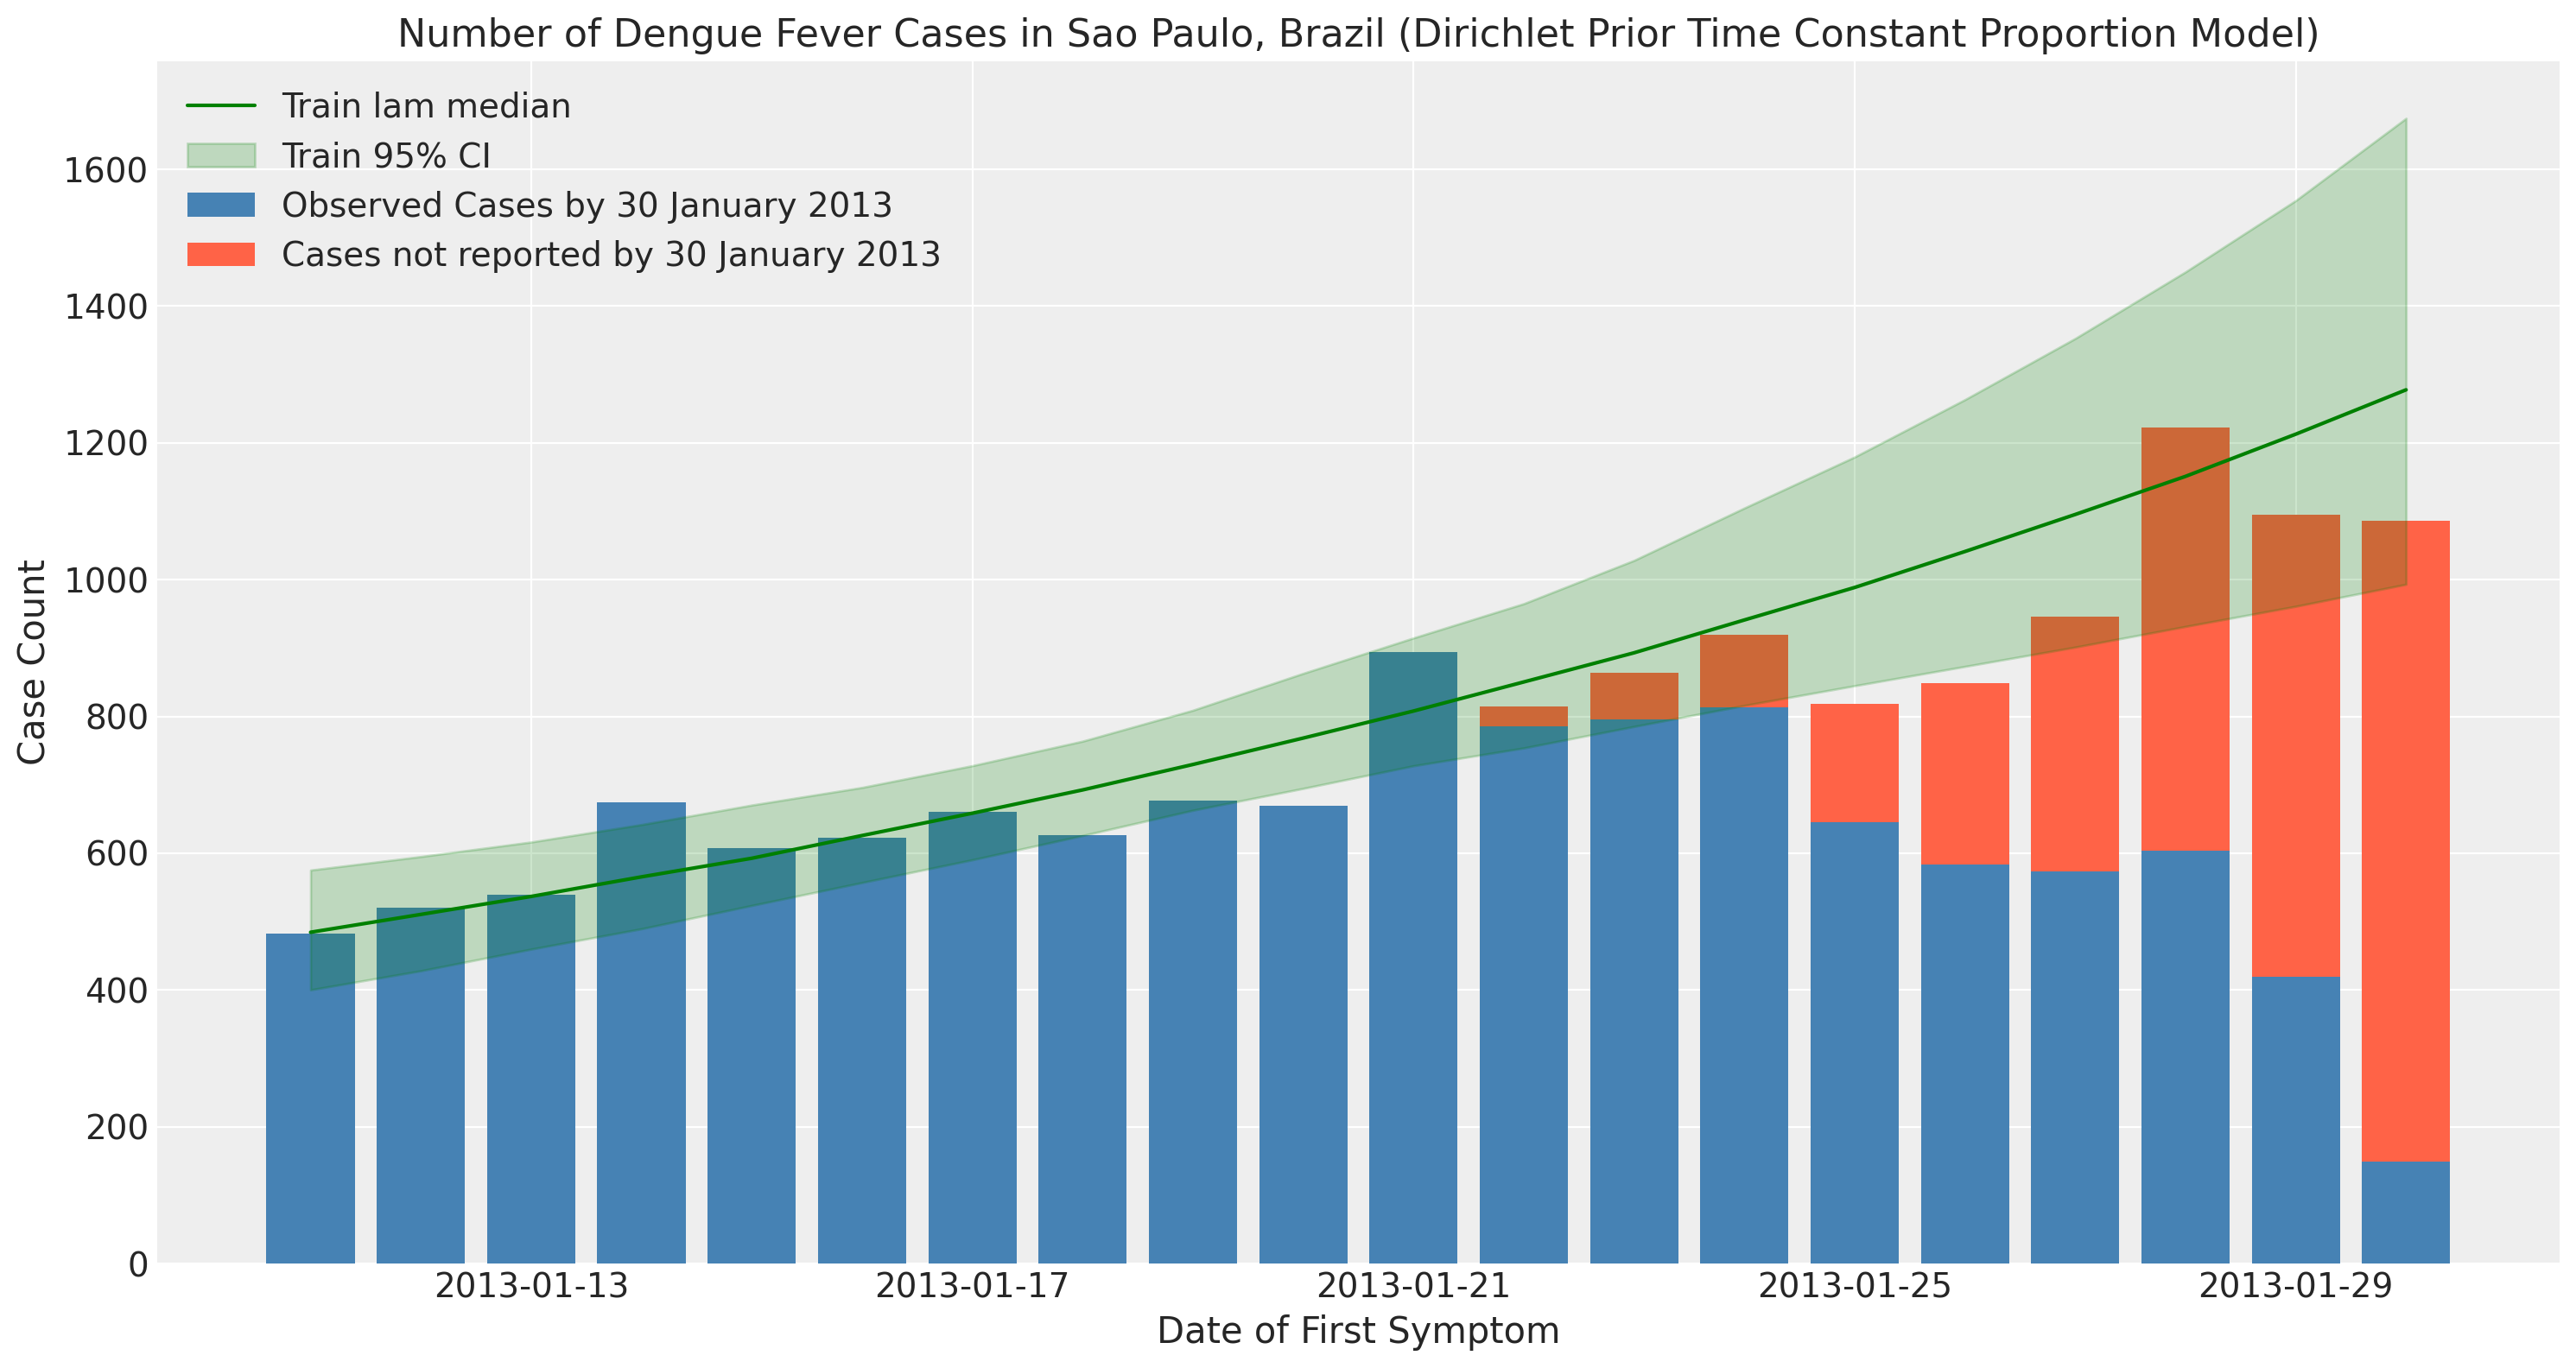

In [57]:
def proportion_net(Z_data, n_hidden=10, output_dim=D):
    T,D = Z_data.shape
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(T*D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h0 = pm.math.flatten(Z_data)
    h1 = pm.math.tanh(pm.math.dot(h0, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw

with pm.Model() as dir_model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)

    # Linear trend parameters
    b0 = pm.Normal("b0", mu=0, sigma=1)   # intercept
    b1 = pm.Normal("b1", mu=0, sigma=1)
    # mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


    # ell = pm.Gamma("ell", alpha=1, beta=20)   # length scale
    # eta = pm.HalfNormal("eta", sigma=2)      # amplitude
    # cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    # gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    # f = gp.prior("f", X=t_shared[:, None])

    # fourier_shared = create_fourier_features(t_shared, n=10, p=7)
    # beta_fourier = pm.Normal("beta_fourier", 0, 0.5, shape=fourier_shared.shape[1])
    # seasonality = pm.Deterministic(
    #     "seasonality", pm.math.dot(fourier_shared, beta_fourier)
    # )
    
    log_lam = b0 + b1*t_shared
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    
    p = pm.Dirichlet("p", a=np.arange(D,0, -1))
    # p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    # p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=0))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p

    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    idata = pm.sample(**sampler_kwargs())

with dir_model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    
p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
print(p_post_samples.median(axis=1))

y_obs = Z_data.sum(1)
y_gap = y_data - y_obs

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)




# Plot stacked bars
plt.figure(figsize=(15, 8))

plt.bar(y_data.index, y_obs, color="steelblue", label=f"Observed Cases by {y_data.index[-1].strftime("%d %B %Y")}")
plt.bar(y_data.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y_data.index[-1].strftime("%d %B %Y")}")

# Plot CI for training data
plt.plot(y_data.index,  med_train, color='green', label="Train lam median")
plt.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.2, label='Train 95% CI')


plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (Dirichlet Prior Time Constant Proportion Model)")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"][-1,:])

<xarray.DataArray 'lam' (sample: 600)> Size: 5kB
array([ 798.02584705, 2052.59307138, 1175.57719466, 1101.45991312,
       1508.55648344, 1904.86965744, 1594.46535632,  936.8236828 ,
       1111.50533173, 1310.66190121, 2938.42305613,  895.06851718,
       1174.75249416, 1726.77602548, 1478.91592845, 1212.53592211,
       1152.50243639, 1857.66154195, 1235.90971569,  519.52767242,
       1350.98041636, 2567.66348053, 1332.66984593, 1393.96745918,
       1764.10740202, 1203.37582848, 1786.76126575, 1167.00180176,
       2019.57324023, 2715.85868981, 1099.70518206,  916.19133622,
       2062.31453867, 2040.34758669, 1405.92413922, 1776.79849942,
       1320.85126526, 2660.79438541, 1843.67031051,  623.23268934,
       1903.56334852, 1666.64854248, 1198.95208751, 1464.97103858,
       1034.07364171, 1443.51457981, 1464.6492352 , 1456.84497216,
       2465.45789173, 2158.74921249, 1306.12714291, 1117.76727436,
       2156.6434301 , 1235.1026187 ,  748.75258893, 2601.89080085,
       1857.6

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_64302/593913964.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  print(az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"][-1,:])
